# amplitude fudger
Here, we take the amplitude right before the onset of instability and fudge it, i.e. we multiple it via a small amplitude, and rewrite it in the HDF file.
Let's go!

In [296]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
utils = reload(utils)
pt = reload(pt)

import dill as pickle
import sys
import os
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import rc

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts,amssymb,bm,mathrsfs}')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.style.use('ggplot')

In [297]:
def load(Nx,Ny,et,test):
    if test == 'mark':
        # base_fn = 'output'
        base_fn = 'output_mark_wave'
    # pydir = '../%s/' %base_fn
    pydir = '/home/ray/git-projects/RKLM_Reference/output_mark_wave/'

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

def get_ens(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=inner,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T[SIDX:NIDX,:]

def get_ens_all(tc, times, sfx , diff, attribute, tag, SIDX, NIDX):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=inner,load_ic=True)
    # ens = ens[:,:,SIDX:NIDX]
    ens = ens[-1].T
    return ens

# here, we load the time series of the simulations
def get_tc(typ, times, Nx, Ny, NIDX, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

#     print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    elem = pickle.load(file)
    node = pickle.load(file)
    dap = pickle.load(file)
    file.close()

    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag, 0, NIDX)
    
    return (ud,mpv,elem,node), tc

In [317]:
Nx, Ny = 301, 120
Nt = 600
tp ='afs'

# define some global attributes:
# ensemble size
N = 1
# take increments or not?
diff = False
# how steps are indexed?
l_typ = 'WINDOW_STEP'
# exclude ghost cells:
inner = False

def get_arrs_at_t(tidx, om=''):

    times0 = [tidx]

    typ = 'bdl_run_S%i%s_a05' %(Nt,om)
    ics,tc = get_tc(typ, times0, Nx, Ny, Ny, tp=tp, et=720.0)

    ud, mpv, elem, node = ics[0], ics[1], ics[2], ics[3]
    phys_time = tc.t_arr

    SIDX = None
    NIDX = None

    tt = times0
    tag = 'ic' if int(times0[0]) == 0 else 'after_full_step'

    rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, SIDX, NIDX)[:]
    arrs_rhou = get_ens_all(tc, tt, typ, False, 'rhou', tag, SIDX, NIDX)[:]
    arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, SIDX, NIDX)[:]
    arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, SIDX, NIDX)[:]
    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, SIDX, NIDX)[:]
    
    arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
    
    return arrs, ud

def get_perturbations(arrs, arrs_noom, factor=100.0):
    arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos = arrs
    rhou_noom, rhov_noom, rhoY_noom, pi_noom, rhos_noom = arrs_noom

    # subtract background state
    if inner:
        slc = slice(2,-2)
    else:
        slc = slice(None,)
    rhobar = mpv.HydroState.rho0[slc].reshape(-1,1)
    Ybar = mpv.HydroState.Y0[slc].reshape(-1,1)
    S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,slc]

    # print(rhobar.shape)
    # print(Ybar.shape)
    # print(S0.shape)
    
    rhos_perturb = rhos - rhos_noom
    rhou_perturb = arrs_rhou - rhou_noom
    rhov_perturb = arrs_rhov - rhov_noom
    rhoY_perturb = arrs_rhoY - rhoY_noom
    pi_perturb = arrs_pi - pi_noom
    
    rhos_perturb /= factor
    rhou_perturb /= factor
    rhov_perturb /= factor
    rhoY_perturb /= factor
    pi_perturb /= factor
    
    return rhos_perturb, rhoY_perturb, rhou_perturb, rhov_perturb, pi_perturb

#     Y = arrs_rhoY / rhos
#     u = arrs_rhou / rhos
#     v = arrs_rhov / rhos

#     rhos_perturb = rhos - rhobar
#     rhos_perturb /= factor

#     Y_perturb = (Y - Ybar)
#     Y_perturb /= factor

#     u_perturb = u / factor
#     v_perturb = v / factor

#     pi_perturb = arrs_pi / factor
    
    # return rhos_perturb, Y_perturb, u_perturb, v_perturb, pi_perturb

tidx = 3
arrs_noom, _ = get_arrs_at_t(tidx,'_noom')

arrs_om, ud = get_arrs_at_t(tidx)
perbs = get_perturbations(arrs_om, arrs_noom)
arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos = arrs_noom

In [299]:
#### just the perturbation terms...
# rhos_perturb, Y_perturb, u_perturb, v_perturb, pi_perturb = perbs
# rhou_p = rhos_perturb * u_perturb
# rhov_p = rhos_perturb * v_perturb
# rhoY_p = rhos_perturb * Y_perturb
# rho_p = rhos_perturb
# pi_p = pi_perturb

# arrs = [arrs_rhou, arrs_rhov, arrs_rhoY, arrs_pi, rhos]
# uhat, vhat, Yhat, p2hat, rhos = arrs

In [318]:
from management import variable as var
Sol = var.Vars(elem.sc, ud)

# Sol.rho[...] = (rhos_perturb + rhobar).T
# Sol.rhou[...] = (Sol.rho.T * u_perturb).T
# Sol.rhov[...] = (Sol.rho.T * v_perturb).T
# Sol.rhoY[...] = (Sol.rho.T * (Y_perturb + Ybar)).T
# mpv.p2_nodes[...] = pi_perturb.T

# Sol.rho[...] = rhos.T + rho_p.T
# Sol.rhou[...] = arrs_rhou.T + rhou_p.T
# Sol.rhov[...] = arrs_rhov.T + rhov_p.T
# Sol.rhoY[...] = arrs_rhoY.T + rhoY_p.T
# mpv.p2_nodes[...] = arrs_pi.T + pi_p.T

rhos_perturb, rhoY_perturb, rhou_perturb, rhov_perturb, pi_perturb = perbs
Sol.rho[...] = rhos.T + rhos_perturb.T
Sol.rhou[...] = arrs_rhou.T + rhou_perturb.T
Sol.rhov[...] = arrs_rhov.T + rhov_perturb.T
Sol.rhoY[...] = arrs_rhoY.T + rhoY_perturb.T
mpv.p2_nodes[...] = arrs_pi.T + pi_perturb.T

# to plot perturbations...
# Sol.rho[...] = rhos_perturb.T
# Sol.rhou[...] = rhou_perturb.T
# Sol.rhov[...] = rhov_perturb.T
# Sol.rhoY[...] = rhoY_perturb.T
# mpv.p2_nodes[...] = pi_perturb.T


# rhobar = mpv.HydroState.rho0[slc].reshape(-1,1)
# Ybar = mpv.HydroState.Y0[slc].reshape(-1,1)
# S0 = (ud.stratification(elem.y)).reshape(1,1,-1)[:,:,slc]
    
# Sol.rho[...] = rhos_perturb.T + rhobar.T
# Sol.rhou[...] = rhou_perturb.T + rhobar.T
# Sol.rhov[...] = rhov_perturb.T + rhobar.T
# Sol.rhoY[...] = rhoY_perturb.T + (rhobar * Ybar).T
# mpv.p2_nodes[...] = pi_perturb.T

In [251]:
ud.output_base_name
ud.output_suffix

'_ensemble=1_301_120_720.000000_bdl_run_S600_a05'

In [319]:
from management.io import io
from physics.gas_dynamics.thermodynamic import ThermodynamicInit

th = ThermodynamicInit(ud)

ud.output_suffix = '_ensemble=1_301_120_720.000000_rstrt_init'
writer = io(ud,restart=False)

writer.write_all(Sol,mpv,elem,node,th,'test')

writing hdf output...test


[3] 0.0


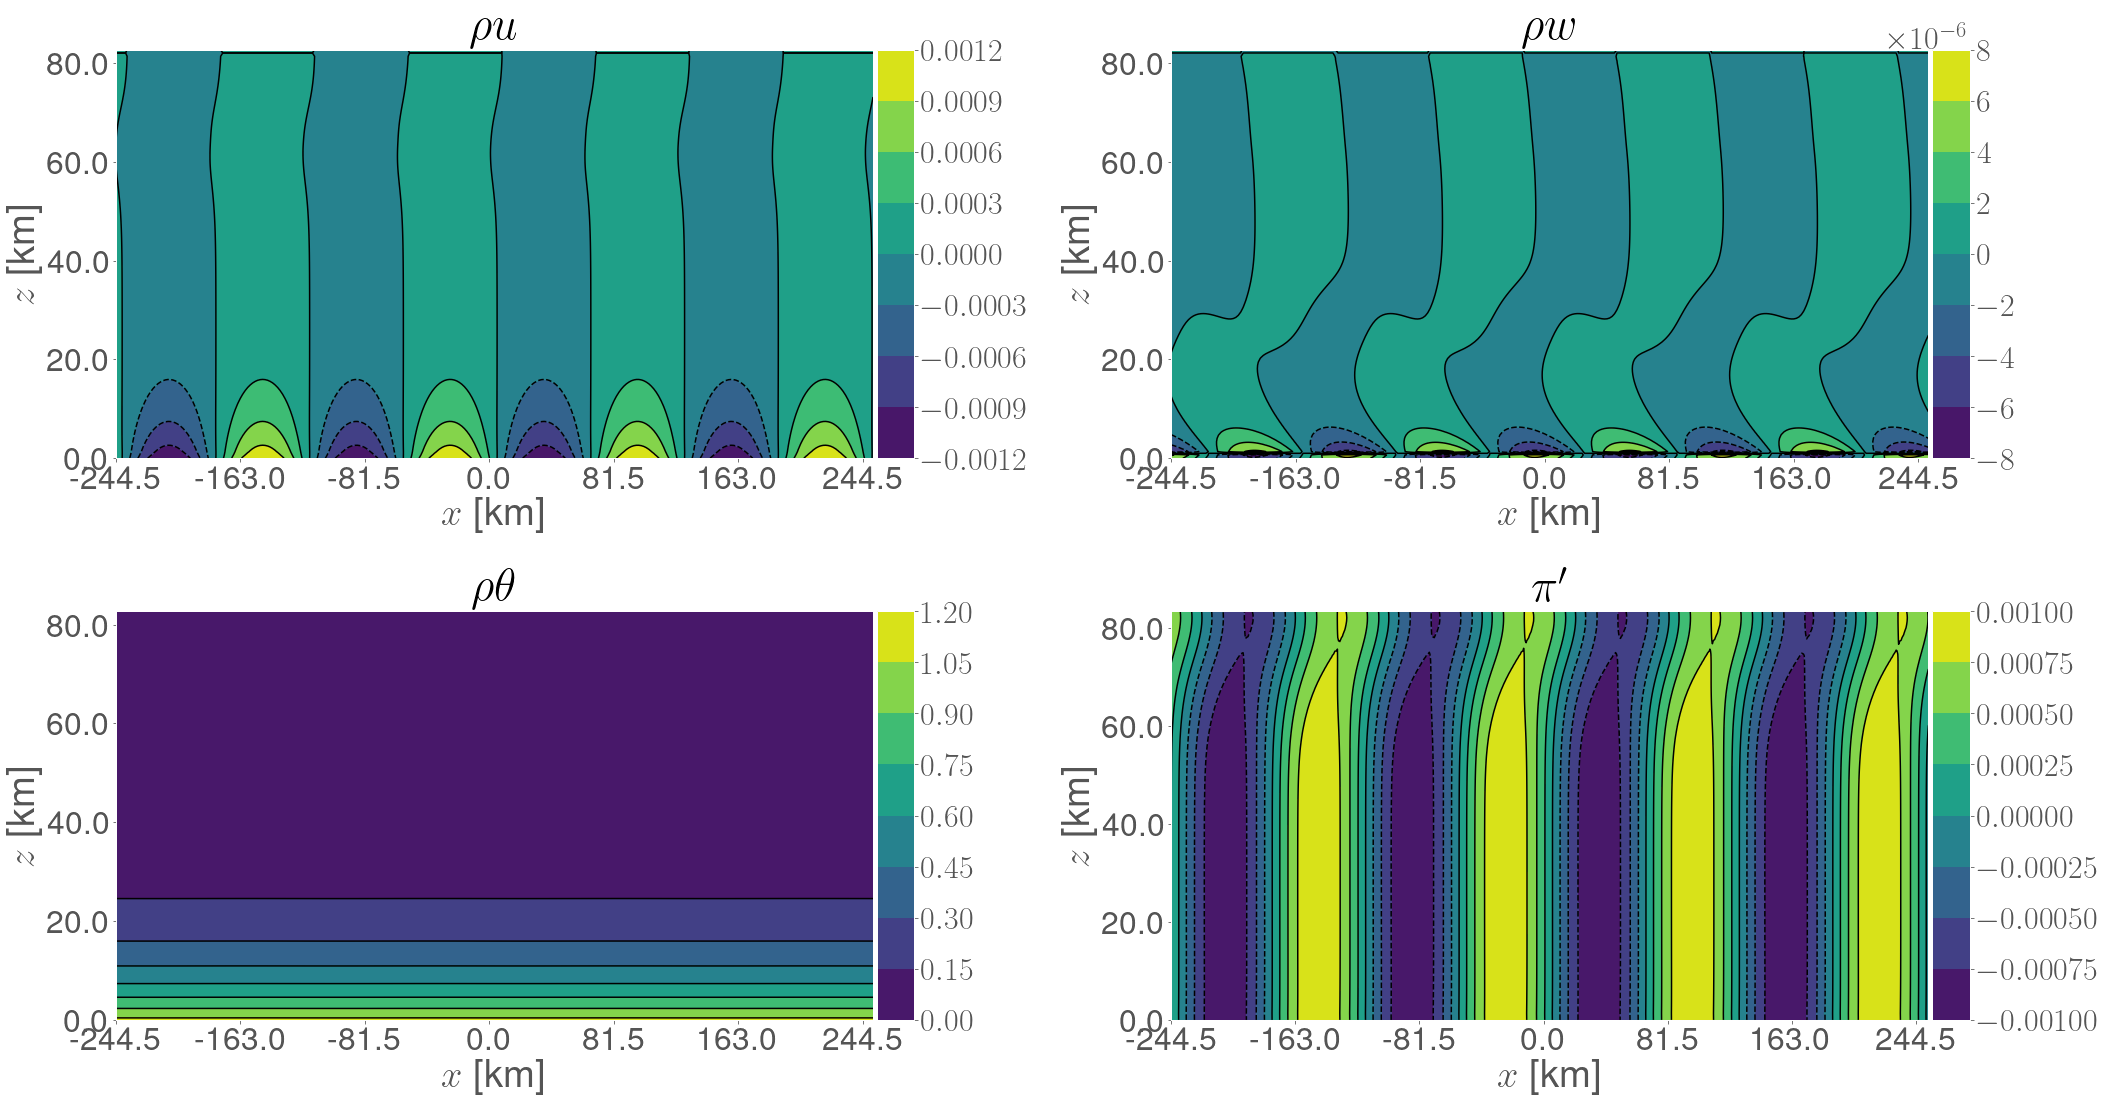

In [320]:
uhat, vhat, Yhat, p2hat, rhos = Sol.rhou.T, Sol.rhov.T, Sol.rhoY.T, mpv.p2_nodes.T, Sol.rho.T

pl_lst = [[uhat, r"$\rho u$"],[vhat, r"$\rho w$"],[Yhat, r"$\rho \theta$"],[p2hat, r"$\pi^\prime$"]]
pl = pt.plotter(pl_lst,ncols=2,figsize=(30,18),sharey=False, sharex=False, fontsize=32)
x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
y_axs = np.array(np.linspace(elem.y,elem.y,6))

x_axs = np.around(x_axs,2) * 10
y_axs = np.around(y_axs,1)

x_loc = np.linspace(0,(Nx-1),7)
y_loc = np.linspace(0,Ny-1,5)
y_axs = np.array([0.0,2.0,4.0,6.0,8.0]) * 10.0

x_label = r'$x$ [km]'
y_label = r'$z$ [km]'

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)

tu = ud.t_ref#/3600
print(tt, phys_time[0]*tu)

_ = pl.plot(method='contour', lvls=None, suptitle='', rect=[0, 0.03, 1.0, 0.95])
# fld_pth = './output_plot/%ix%i/S%i/%s' %(Nx,Ny,Nt,fld)
# if not os.path.exists(fld_pth):
#     os.makedirs(fld_pth)

# pl.save_fig('%s/lamb_%s_%.3d' %(fld_pth, tcase,ct), format='.pdf')
plt.show()
# plt.close()

In [32]:
print(rhos.max())

0.96323603


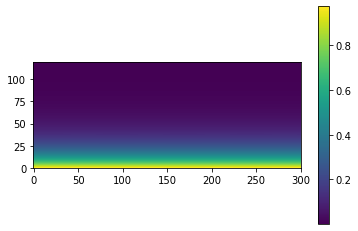

In [35]:
plt.figure()
plt.imshow(arrs_rhoY[-1].T, origin='lower')
plt.colorbar()
plt.show()